 # Lecture 13: Training deep neural networks

![](https://www.tensorflow.org/images/colab_logo_32px.png)
[Run in colab](https://colab.research.google.com/drive/1ftihrW-_2cIzCkA3TYScFgoOe1bQwTrT)

In [1]:
import datetime
now = datetime.datetime.now()
print("Last executed: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Last executed: 2021-02-11 14:21:19


In [2]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_state(seed=42):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Vanishing and exploding gradients

Training typically relies on gradients.

*Vanishing gradients problem*: For deep networks, gradients in lower layers can become very small.  Hence, corresponding weights are not updated during training.

*Exploding gradients problem*: In some situations (typically recurrent neural networks) gradients can become very large.  Hence, weight updates are very large and the training algorithm may not converge.

In general deep neural networks can suffer from *unstable gradients*.

### Problematic activation functions

One common cause of vanishing gradients in the past was the use of the sigmoid activation function (and unit Gaussian initialisation).

In [3]:
def logit(z):
    return 1 / (1 + np.exp(-z))

(-5.0, 5.0, -0.2, 1.2)

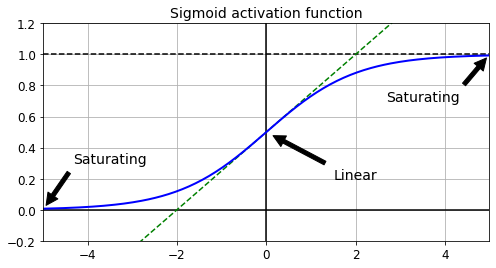

In [4]:
z = np.linspace(-5, 5, 200)
 
plt.figure(figsize=(8,4))
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

Variance of outputs grows at each layer.  Final layers essentially saturate.  Gradients on final layers then very small and when propagate gradients back with back-propagation then get vanishing gradients.

### Weight initialisation

To avoid this problem need signals and gradents to *not* decay as propagating through network.

Avoid decaying signals/gradients by promoting equal variance at outputs and inputs of layer.

Can be promoted by random initialisation of weights to follow Gaussian with standard deviation:

\begin{eqnarray}
\text{Sigmoid activation:} \quad\quad & \sigma = \sqrt{\frac{2}{n_{\rm inputs}+n_{\rm outputs}}} \\
\text{Hyperbolic tangent activation:} \quad\quad & \sigma = 4\sqrt{\frac{2}{n_{\rm inputs}+n_{\rm outputs}}} \\
\text{ReLU activation:} \quad\quad & \sigma = \sqrt{2}\sqrt{\frac{2}{n_{\rm inputs}+n_{\rm outputs}}} \\
\end{eqnarray}

where $n_{\rm inputs}$ and $n_{\rm outputs}$ are the number of input and output nodes, respectively, for the layer.

There are a lot of different weight initialisation strategies.

#### Weight initialisation in TensorFlow

In [5]:
import tensorflow as tf
from tensorflow import keras

In [6]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

Can often simply set initialiser when defining layer.

In [7]:
reset_state()

keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

Or can set up a `VarianceScaling` object directly.

In [8]:
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation="sigmoid", kernel_initializer=he_avg_init)

### Non-saturating activation functions

ReLU activation behaves much better than the sigmoid in deep networks since it does not saturate for positive values (and it is fast to compute).

However, the ReLU does suffer from the *dying neuron* problem.

In this senario neurons effectively die and only output zero.  The neuron is unlikely to come back to life since the gradient of the ReLU activation function is zero for negative inputs.

#### Leaky ReLU

The *leaky ReLU* avoids this problem and is defined by

$$
\text{LeakyReLU}_\alpha(z) = \max(\alpha z, z),
$$

where the hyperparameter $\alpha$ defines how much the leaky ReLU leaks (typically $\alpha=0.01$).

Let's plot the Leaky ReLU activation function for $\alpha=0.05$.

In [9]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

(-5.0, 5.0, -0.5, 4.2)

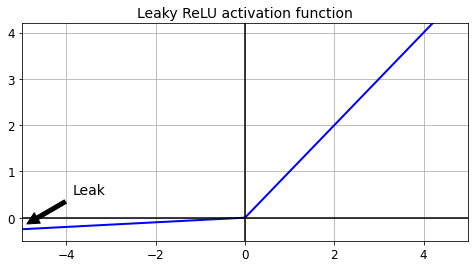

In [10]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(8,4))
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

#### ELU

Another alternative is the *exponental linear unit* (ELU).

In [11]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Let's plot the ELU activation function for $\alpha=1$.

(-5.0, 5.0, -2.2, 3.2)

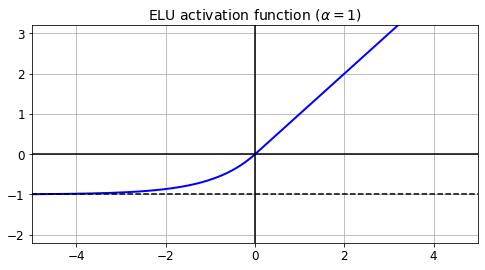

In [12]:
plt.figure(figsize=(8,4))
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

Properties:
- Non-zero gradient for $z<0$ to avoid dying neuron issue.
- Smooth so gradients well defined.
- But is slower to compute.

#### Activations functions in TensorFlow

TensorFlow supports a lot of activation functions.

In [13]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

Can again simply set when definiting layer or can construct directly.

In [14]:
reset_state()
keras.layers.Dense(10, activation="elu", name="hidden1")

In [15]:
reset_state()
keras.layers.Dense(10, activation=keras.layers.Activation("elu"), name="hidden1")

## Batch normalisation

While weight normalisation can reduce gradient problems at the beginning of training, it does not guarantee that these problems won't resurface during training.

*Batch normalisation* adds normalisation during training to address these issues.

Consists of zero-centering and normalising inputs just before the activation function, followed by shifting and scaling the result.  The shift and scale are considered additional parameters that are learnt during training.

This approach allows training to select the appropriate scale and shift (mean) for each layer.

The mean and standard deviation of the unnormalised inputs are computed for each mini-batch, hence the name *batch normalisation*.

When the trained network is applied to the test set there are no batches, so instead the entire *training* set's mean and standard deviation are used.

### Batch normalisation in TensorFlow

In [16]:
reset_state()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[28, 28]), keras.layers.BatchNormalization(),
keras.layers.Dense(n_hidden1, activation="elu", kernel_initializer="he_normal"), keras.layers.BatchNormalization(),
keras.layers.Dense(n_hidden2, activation="elu", kernel_initializer="he_normal"), keras.layers.BatchNormalization(),
keras.layers.Dense(n_outputs, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

In [17]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

**Exercises:** *You can now complete Exercise 1 in the exercises associated with this lecture.*

## Pretraining and transfer learning

A deep network trained for one task can often be adapted for a similar task.

Reuse lower layers of network trained for another task.

<!-- <img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture13_Images/transfer_learning.png" style="height: 350px;"/> -->

![](https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture13_Images/transfer_learning.png)

[Credit: Geron]

For transfer learning to be successful the data must have similar low-level features.

### Reusing a Keras model

Let's work through a transfer learning example.

Split the fashion MNIST training set into two:
* `X_train_A`: all images of all items, except sandals and shirts (classes 5 and 6).
* `X_train_B`: first 200 images of sandals or shirts.

The validation set and the test set are split similarly, but without restricting the number of images.

Dataset B corresponds to a simple problem (binary classification) but we only have a small number of training instances. 

Dataset A corresponds to a more difficult problem (classification between 8 classes) but we have much more data.

We will attempt to transfer knowledge from setting A to B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). 

Aside: Note that only patterns that occur in the same location can be reused since we are using `Dense` layers (CNNs will be much more effective in tranferring information detected anywhere in the image due to their translational invariance properties, as we'll see in the CNN lecture).

#### Set up data

In [18]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [19]:
X_train_A.shape, X_train_B.shape

((43986, 28, 28), (200, 28, 28))

In [20]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [21]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

#### Define, compile, fit and save model on dataset A

In [22]:
reset_state()
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

In [24]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [25]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 4s 2ms/step - loss: 0.9248 - accuracy: 0.6994 - val_loss: 0.3890 - val_accuracy: 0.8677
Epoch 2/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3651 - accuracy: 0.8748 - val_loss: 0.3289 - val_accuracy: 0.8824
Epoch 3/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3182 - accuracy: 0.8897 - val_loss: 0.3013 - val_accuracy: 0.8991
Epoch 4/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3048 - accuracy: 0.8954 - val_loss: 0.2892 - val_accuracy: 0.9013
Epoch 5/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2803 - accuracy: 0.9029 - val_loss: 0.2774 - val_accuracy: 0.9066
Epoch 6/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2700 - accuracy: 0.9080 - val_loss: 0.2733 - val_accuracy: 0.9071
Epoch 7/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2625 - accuracy: 0.9091 - val_loss: 0.2720 - val_accuracy:

We achieve an accuracy ~92%, which is reasonable.

In [26]:
model_A.save("my_model_A.h5")

#### Repeat on dataset B

In [27]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [28]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [29]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 38ms/step - loss: 1.0360 - accuracy: 0.4975 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 12ms/step - loss: 0.5883 - accuracy: 0.6971 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 13ms/step - loss: 0.4380 - accuracy: 0.8854 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 12ms/step - loss: 0.4021 - accuracy: 0.8712 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 12ms/step - loss: 0.3361 - accuracy: 0.9348 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 12ms/step - loss: 0.3113 - accuracy: 0.9233 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 12ms/step - loss: 0.2817 - accuracy: 0.9299 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

We achieve an accuracy ~97% since this is an easier problem (binary classification).

However, we could do better by transferring information from setting A.

### Freezing lower layers

The lower layers of the first network have already learnt low-level features for the first task, so they can be reused as they are. 

That is, we freeze their weights so that they are not altered during subsequent training of the new network.

We will take all layers from model A and then add a final output layer for our binary classification problem.

In [30]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1]) # Reuse all layers except output.
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` now share layers.  When you train on `model_B_on_A` that will also impact `model_A`.

To avoid this you can clone a model.

Let's freeze all layers except the final dense output layer.

In [31]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [32]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 36ms/step - loss: 0.6108 - accuracy: 0.6233 - val_loss: 0.5812 - val_accuracy: 0.6379
Epoch 2/4
7/7 [==============================] - 0s 12ms/step - loss: 0.5506 - accuracy: 0.6619 - val_loss: 0.5439 - val_accuracy: 0.6826
Epoch 3/4
7/7 [==============================] - 0s 13ms/step - loss: 0.4861 - accuracy: 0.7482 - val_loss: 0.5121 - val_accuracy: 0.7150
Epoch 4/4
7/7 [==============================] - 0s 11ms/step - loss: 0.4861 - accuracy: 0.7455 - val_loss: 0.4835 - val_accuracy: 0.7333


Even with just one trained layer and a few epochs, our model is starting to learn the new problem.

Now let's unfreeze and lower layers and train the full model to fine-tune it.

In [33]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [34]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 1s 35ms/step - loss: 0.4349 - accuracy: 0.7774 - val_loss: 0.3452 - val_accuracy: 0.8641
Epoch 2/16
7/7 [==============================] - 0s 13ms/step - loss: 0.2956 - accuracy: 0.9143 - val_loss: 0.2600 - val_accuracy: 0.9270
Epoch 3/16
7/7 [==============================] - 0s 12ms/step - loss: 0.2030 - accuracy: 0.9777 - val_loss: 0.2111 - val_accuracy: 0.9554
Epoch 4/16
7/7 [==============================] - 0s 12ms/step - loss: 0.1751 - accuracy: 0.9789 - val_loss: 0.1793 - val_accuracy: 0.9696
Epoch 5/16
7/7 [==============================] - 0s 12ms/step - loss: 0.1348 - accuracy: 0.9809 - val_loss: 0.1564 - val_accuracy: 0.9757
Epoch 6/16
7/7 [==============================] - 0s 12ms/step - loss: 0.1173 - accuracy: 0.9973 - val_loss: 0.1396 - val_accuracy: 0.9797
Epoch 7/16
7/7 [==============================] - 0s 12ms/step - loss: 0.1140 - accuracy: 0.9931 - val_loss: 0.1268 - val_accuracy: 0.9838
Epoch 8/16
7/7 [===========

In [35]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.1408 - accuracy: 0.9705


[0.14084088802337646, 0.9704999923706055]

In [36]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.0682 - accuracy: 0.9930


[0.06821806728839874, 0.9929999709129333]

### Model gardens

Many trained Tensor Flow models are available at 
[https://github.com/tensorflow/models](https://github.com/tensorflow/models).

## Improved optimizers

Although standard (stochastic) gradient descent is very effective it can still be slow for deep networks.

There are a number of more advanced optimizers that provide improvements, e.g.:
- Momentum optimization
- Nesterov accelerated gradient
- AdaGrad
- RMSProp
- Adam optimization
- ...

Recall gradient descent, with cost function $J(\theta)$ and gradients $\nabla_\theta J(\theta)$, proceeds simply by updating the weights $\theta$ by taking a step $\eta$ (learning rate) in the direction of the gradient:

$$\theta \leftarrow \theta - \eta \nabla_\theta J(\theta)$$

### Momentum optimization

Momentum optimization uses the gradients to modify a momentum vector and uses the momentum to update the weights:

1. $m \leftarrow \beta m + \eta \nabla_\theta J(\theta)$
2. $\theta \leftarrow \theta - m$

Gradient is used as an acceleration rather than speed.  Can help to traverse plateaus and to avoid local minima.

The additional hyperparameter $\beta$ is introduced as a friction term to avoid the momentum growing too large (typically $\beta \sim 0.9$).

### Nesterov accelerated gradient

Nesterov accelerated gradient is a variant of momentum optimization where the gradient is computed further ahead in the direction of the momentum:

1. $m \leftarrow \beta m + \eta \nabla_\theta J(\theta + \beta m)$
2. $\theta \leftarrow \theta - m$

In general the momentum will be pointing toward the optimum and so Nesterov modification typically provides an improvement over standard momentum optimization.

### AdaGrad

AdaGrad scales down the gradient vector along the steepest direction by incorporating a gradient squared term:

1. $s \leftarrow s + \nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta)$
2. $\theta \leftarrow \theta - \eta \nabla_\theta J(\theta) \oslash \sqrt{s+\epsilon}$

Note that $\otimes$ and $\oslash$ are elementwise multiplication and division, respectively.

The parameter $\epsilon$ is introduced for numerical stability (typically $\epsilon\sim 10^{-10}$).



Basically, AdaGrad correspondings to an *adaptive learning rate* where the learning rate is decayed faster for steep directions.

Consequently, it requires much less tuning of the learning rate $\eta$.

<!-- <img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture13_Images/ada_grad.png" style="height: 500px;"/> -->

![](https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture13_Images/ada_grad.png)

[Credit: Geron]

### RMSProp

RMSProp extends AdaGrad by introducing an exponential decay in the accumulated squared gradient:

1. $s \leftarrow \beta s + (1-\beta) \nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta)$
2. $\theta \leftarrow \theta - \eta \nabla_\theta J(\theta) \oslash \sqrt{s+\epsilon}$

(Typically $\beta\sim 0.9$.)

Avoids the problem where AdaGrad slows down too fast and so doesn't converge to the global optimum.

### Adam optimization

Adam optimization combines momentum and RMSProp:

1. $m \leftarrow \beta_1 m + (1-\beta_1) \nabla_\theta J(\theta)$
2. $s \leftarrow \beta_2 s + (1-\beta_2) \nabla_\theta J(\theta)\otimes\nabla_\theta J(\theta)$
3. $m \leftarrow \frac{m}{1-\beta_1^{t}}$, where $t$ is the iteration number 
4. $s \leftarrow \frac{s}{1-\beta_2^{t}}$, where $t$ is the iteration number
5. $\theta \leftarrow \theta - \eta m \oslash \sqrt{s+\epsilon}$

Steps 3 and 4 are introduced to boost $m$ and $s$ at the beginnning of training (since they are initialed to 0 they can otherwise be low at the beginning).

(Typically $\beta_1 \sim 0.9$, $\beta_2 \sim 0.999$.)

## Regularization

Deep networks have many parameters (sometimes millions) and so are prone to overfitting.

Regularization therefore becomes increasingly important.

### Early stopping

A simple regularization strategy is to end training early, e.g. when performance on validation set starts to degrade.

Although early stopping works well, other regularisation techniques can lead to better performance.

### $\ell_2$ and $\ell_1$ regularization

*Tikhonov* regularization adopts $\ell_2$ regularising term (also called *Ridge regression*):


$$ R(\theta) = \frac{1}{2} \sum_{j=1}^n \theta_j^2 = \frac{1}{2}  \theta^{\rm T}\theta.$$


*Lasso* regularization adopts $\ell_1$ regularising term:

$$ R(\theta) =\sum_{j=1}^n \left\vert \theta_j \right\vert .$$

*Elastic net* regularization provides a mix of Tikhonov and Lasso regularization, controlled by mix ratio $r$:

$$ R(\theta) =  r\sum_{j=1}^n \left\vert \theta_j \right\vert + \frac{1-r}{2} \sum_{j=1}^n \theta_j^2.$$

- For $r=0$, corresponds to Tikhonov regularization.
- For $r=1$, corresponds to Lasso regularization.

### Dropout

Dropout is a very popular and effective regularlisation technique developed by [Geoff Hinton in 2012](http://www.jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf).

Dropout involves simply dropping each neuron for a given training set with probability $p$.

<!-- <img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture13_Images/dropout.png" style="height: 350px;"/> -->

![](https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture13_Images/dropout.png)

[Credit: Geron]

Dropout encourages each neuron to be as effective as possible individually and not to rely heavily on a few nearby neurons but to consider all input neurons carefully.

The probability $p$ is called the *dropout rate* (typically $p \sim 0.5$).

After training the neurons don't get dropped.

The number of inputs of active neurons is lower when dropout is applied during training, than when the network is applied during testing.  

For example, if $p=0.5$, on average there are half as many input neurons during training than when testing.  During testing each neuron will get an input signal (approximately) twice as large as during training.

It is important to account for this difference.

To compensate, after training each neurons input weights are multiplied by the keep probability $1-p$ before applying the network to test data.

### Data augmentation

Data augmentation can be applied both as a regularization technique and to increase the volume of the training set.

Essentially, new training instances are created from the original training set.

For example, for images, data augmentation can be performed by rotating, shifting, scaling, flipping, changing the contrast, ..., of the original images in the training data-set.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture13_Images/data_augmentation.png" style="height: 500px;"/>

[Credit: Geron]

Appropriate data augmentation strategies depend on the type of data under consideration.

Typically training instances are generated on the fly to avoid additional storage requirements.  

Tensor Flow has built in functionality for many transformations for image data, making data augmentation for image data straightforward.